In [ ]:
# Name: Rohith Ganesan
# Student ID: 20553375


# Dataset: Tamil Hate Speech and Abusive Comment Detection
# Machine Learning Models Implemented - SVM, Logestic Regression, K-Nearest Neighbous , Random Forest, Multilayer Perceptron.
# Deep Learning Models Implements - RNN, Bi-LSTM, BERT.
# Data Augmented for Deep learning Models under (33%, 50%, 75%) of the training Data.

# Importing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install emoji


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 9.1 MB/s eta 0:00:00


In [ ]:
# Importing the required packages
import pandas as pd
import numpy as np
import re
import timeit
import warnings
import string
import seaborn as sn
import matplotlib.pyplot as plt
from PIL import Image
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.probability import FreqDist
import emoji

# Importing Sci-kit learn functions for evaluation and dataset analysis purpose
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tkinter import ttk
from tkinter import *
import time
import plotly.figure_factory as ff

# Loading the ML Models used to classify the data into hate, offensive and neither category
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Preprocessing

In [ ]:
# Function used to pre-process the dataset
import re
import emoji

def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r'', text)

def preprocessing(text):
    #print(text)
    text = re.sub(r'@\S+', '', text)  # Remove @mentions
    text = re.sub(r'http\S+', '', text)  # Remove URLs starting with http
    text = re.sub(r'www\S+', '', text)  # Remove URLs starting with www
    text = re.sub(r'#\S+', '', text)  # Remove hashtags
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r' +', ' ', text).strip()  # Remove extra spaces and strip text
    text = remove_emoji(text)  # Remove emojis using the custom function
    return text


In [ ]:
# Loading the Data set used for Validation and Training
df_train_orig = pd.read_csv(r"/content/drive/MyDrive/Disseration UON/Datasets/tamil_train.csv",sep="\t",names=["class","comments"])
df_dev_orig = pd.read_csv(r"/content/drive/MyDrive/Disseration UON/Datasets/tamil_test.csv",sep="\t",names=["class","comments"])

In [ ]:
# Printing first 'n' data from the loaded training data dataframe
n = 10
df_train_orig.head(n)

,class,comments
0,Hope-Speech,உங்கள் பேச்சை எதிர்பார்த்தேன். நல்ல விளக்கம் ...
1,None-of-the-above,எச். ராசாவால் இராமருக்கே இழிவு. இவர் எல்லாம் ...
2,None-of-the-above,கல்யாணம்னு வரும்போது தான் சாதி முக்கியம் எங்க...
3,None-of-the-above,Tentu Kottai ஐயா நான் தமிழ் இந்து.
4,Homophobia,Tamil selvan அடே தேவடியாவுக்கு பிரந்தவனே பச்ச...
5,None-of-the-above,bro நீங்க பேசறதெல்லாம் கேக்க கேக்க இரவு துக்கம...
6,None-of-the-above,S_1 B_2 Narmada.D பெற்ற பிள்ளையை படிக்க வைத்த...
7,None-of-the-above,பாஜக மற்றும் அது சார்ந்த அமைப்புகள் இந்து மற்ற...
8,Misandry,தேவிடியா; பயா H Raja
9,Homophobia,+பிரபல நாட்டாமை என் வீட்டுக்கு வா சுண்ணி ஊம்பி...


In [ ]:
# Checking whether any data with null entries are present or not
df_train_orig[df_train_orig["comments"].isna()]

,class,comments


In [ ]:
# Printing first 'n' data from the loaded validation data dataframe
df_dev_orig.head(n)

,class,comments
0,None-of-the-above,மனைவியை விரும்பினால் சுவாரசியம் வரும்
1,Misogyny,மதுவாந்தி ஒரு கருங்காலி பெண்ணினத்திற்கே ஒரு அவ...
2,None-of-the-above,எச்ச.ராஜா ஓரு .........உங்கள் கருத்து........
3,None-of-the-above,பிராமின்ஸ்லையும் மனசாட்சி உள்ள ஒரு மனுஷன் இருக...
4,Misandry,Comedy எச்சில் ராஜா
5,None-of-the-above,வாழ்த்துகள் திரு.இயேசுராஜ் அவா்களுக்கு
6,None-of-the-above,ஜெயலலிதாவால் தப்பியது ஆனால் கடவுள் ஜெயலலிதா மர...
7,None-of-the-above,Storm Breaker எங்கப்பா போன டைம் பாஸ் ஆக மாட்ட...
8,None-of-the-above,எச்ச ராஜா உனக்கு இதே வேளைய
9,None-of-the-above,கடைசியில் அமர்ந்திருந்த அக்கா என்ன ஆச்சு னு கே...


In [ ]:
# Checking whether any data with null entries are present or not
df_dev_orig[df_dev_orig["comments"].isna()]

,class,comments


In [ ]:
# Null entries filled with unknown tags
df_train = df_train_orig.fillna("unknown")
df_dev = df_dev_orig.fillna("unknown")

In [ ]:
# Printing total amount of data with null entries
print(df_train.isna().sum(),"\n")
print(df_dev.isna().sum())

class       0
comments    0
dtype: int64 

class       0
comments    0
dtype: int64


In [ ]:
# No. of classes present for this tamil dataset
n_classes = len(np.unique(df_train["class"]))
print("Number of classes:",n_classes)

Number of classes: 9


In [ ]:
# Defining the label-encoder
le = LabelEncoder()

In [ ]:
# Obtaining the training and validation datasets
X_train = [(preprocessing(i)) for i in df_train["comments"]]
X_val = [(preprocessing(i)) for i in df_dev["comments"]]

Y_train = le.fit_transform(np.array(df_train_orig["class"]))
Y_val = le.transform(np.array(df_dev_orig["class"]))

உங்கள் பேச்சை எதிர்பார்த்தேன். நல்ல விளக்கம்  அருமை.  நியாயமான முறையில் பதிவு செய்துள்ளீர்கள்.  நீண்ட காலம் வாழ்வதற்கு வாழ்த்துக்கள்.
எச். ராசாவால் இராமருக்கே  இழிவு. இவர் எல்லாம் இராமர் பரம்பரையாம்.
கல்யாணம்னு  வரும்போது தான் சாதி முக்கியம் எங்களுக்கு
Tentu Kottai ஐயா நான் தமிழ் இந்து.
Tamil selvan  அடே தேவடியாவுக்கு பிரந்தவனே பச்சத் தேவடியாவுக்கு பிரந்தவனே ... கொம்மா புண்டைல பூள பார்க் பண்ணுறேன்.என் சுன்னிய ரொம்பவும் ரசிச்சு ரசிச்சு ஊம்புரீயேடா எச்சப்புன்ட Tamil Selva...
bro நீங்க பேசறதெல்லாம் கேக்க கேக்க இரவு துக்கம் வரமாட்டங்குது
S_1 B_2 Narmada.D  பெற்ற பிள்ளையை படிக்க வைத்து aalakuvathu ஒவ்வொரு petrorin கடமை
பாஜக மற்றும் அது சார்ந்த அமைப்புகள் இந்து மற்றும் பிரமாண சமூகத்தின் கட்சியே அல்ல...
தேவிடியா; பயா  H   Raja
+பிரபல நாட்டாமை என் வீட்டுக்கு வா சுண்ணி ஊம்பி விடு
ரகுராம் ராஜன் நேர்மையான மனிதர்.
திரு.ஆனந்த சீனிவாசன் அவர்கள் சிறந்த மனிதர் 👌👋👋👋
பாரபட்சம் தாண் அதில் என்ன சந்தேகம்???
நீச்சல் குள மரணம் | ஜெயலலிதாவால் தப்பியது PSBB | ஆனந்த் சீனிவாசன் | PSBB SCHOOL | Tamil Kelvi - அரும

(array([ 36.,   8.,  11., 104.,  24., 346.,   0.,   2.,  29.]),
 array([0.        , 0.88888889, 1.77777778, 2.66666667, 3.55555556,
        4.44444444, 5.33333333, 6.22222222, 7.11111111, 8.        ]),
 <BarContainer object of 9 artists>)

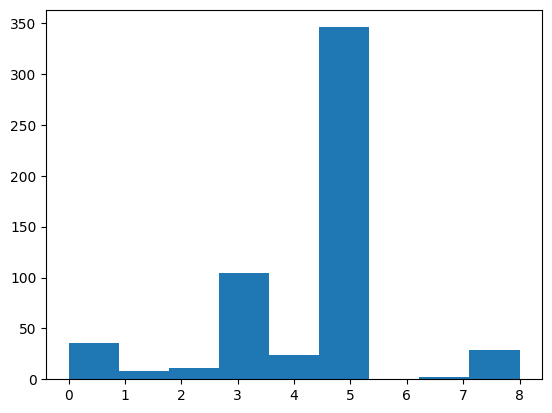

In [ ]:
# Histography to depict class/label wise data distribution
plt.hist(Y_val,bins=n_classes)

In [ ]:
# Printing the class names
le.classes_

array(['Counter-speech', 'Homophobia', 'Hope-Speech', 'Misandry',
       'Misogyny', 'None-of-the-above', 'Not-Tamil', 'Transphobic',
       'Xenophobia'], dtype=object)

In [ ]:
# Converting train data to dataframe
df = pd.DataFrame(X_train)

In [ ]:
# Converting the string type labels to corresponding numeric tags
df["class"] = le.transform(df_train["class"])
df.head(n)

,0,class
0,உங்கள் பேச்சை எதிர்பார்த்தேன். நல்ல விளக்கம் அ...,2
1,எச். ராசாவால் இராமருக்கே இழிவு. இவர் எல்லாம் இ...,5
2,கல்யாணம்னு வரும்போது தான் சாதி முக்கியம் எங்கள...,5
3,tentu kottai ஐயா நான் தமிழ் இந்து.,5
4,tamil selvan அடே தேவடியாவுக்கு பிரந்தவனே பச்சத...,1
5,bro நீங்க பேசறதெல்லாம் கேக்க கேக்க இரவு துக்கம...,5
6,s_1 b_2 narmada.d பெற்ற பிள்ளையை படிக்க வைத்த...,5
7,பாஜக மற்றும் அது சார்ந்த அமைப்புகள் இந்து மற்ற...,5
8,தேவிடியா; பயா h raja,3
9,+பிரபல நாட்டாமை என் வீட்டுக்கு வா சுண்ணி ஊம்பி...,1


In [ ]:
# TF-IDF relation computed for the training and validation dataset - char_wb, char and word analyzers
tfidf_vec = TfidfVectorizer(ngram_range=(1,5),analyzer="char_wb",max_features=2000)
tfidf_vec.fit(X_train,Y_train)
tfidf_vec_char = TfidfVectorizer(ngram_range=(1,5),analyzer="char",max_features=2000)
tfidf_vec_char.fit(X_train,Y_train)
tfidf_vec_word = TfidfVectorizer(ngram_range=(1,5),analyzer="word",max_features=2000)
tfidf_vec_word.fit(X_train,Y_train)

TfidfVectorizer(max_features=2000, ngram_range=(1, 5))

In [ ]:
# Converting the transformed values to array
X_train_charwb =(tfidf_vec.transform(X_train)).toarray()
X_test_charwb = (tfidf_vec.transform(X_val)).toarray()
X_train_char =(tfidf_vec_char.transform(X_train)).toarray()
X_test_char = (tfidf_vec_char.transform(X_val)).toarray()
X_train_word =(tfidf_vec_word.transform(X_train)).toarray()
X_test_word = (tfidf_vec_word.transform(X_val)).toarray()

# Machine Learning Models

In [ ]:
# Function for Logistic Regression Model
def run_logreg(x_train, y_train, x_test, y_test):

    clf = LogisticRegression(penalty="none", random_state=0, solver='saga')
    clf.fit(x_train, y_train)
    predicted = clf.predict(x_test)
    return clf, predicted, y_test

# Function for Linear SVM Model
def run_linsvm(x_train, y_train, x_test, y_test):
    clf = LinearSVC()
    clf.fit(x_train, y_train)
    predicted = clf.predict(x_test)
    return clf, predicted, y_test

# Function for Multilayer Perceptron Model
def run_mlptron(x_train, y_train, x_test, y_test):
    clf = MLPClassifier()
    clf.fit(x_train, y_train)
    predicted = clf.predict(x_test)
    return clf, predicted, y_test

# Function for Random Forest Model
def run_rand_forest(x_train, y_train, x_test, y_test):
  clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
  clf.fit(x_train, y_train)
  predicted = clf.predict(x_test)
  return clf, predicted, y_test

# Function for KNN Model
def run_KNN(x_train, y_train, x_test, y_test):
  clf = KNeighborsClassifier()
  clf.fit(x_train, y_train)
  predicted = clf.predict(x_test)
  return clf, predicted, y_test

In [ ]:
# Function used to obtain the evaluation metrics -> Confusion Matrix, Class wise report for precision, recall and F1-score
def show_results(predicted, y_test, labels=[0,1,2]):
    clsr = classification_report(y_test, predicted, output_dict=True)
    cm = confusion_matrix(y_test, predicted)

    cr_df = pd.DataFrame(clsr).transpose()
    print(cr_df)

    fig = ff.create_annotated_heatmap(cm)
    fig.update_layout(title_text='Confusion Matrix')
    fig.show()

In [ ]:
# Testing for KNN
clf, pred, y_test = run_KNN(X_train_charwb, Y_train, X_test_charwb, Y_val)
show_results(pred, Y_val)

              precision    recall  f1-score     support
0              0.161017  0.527778  0.246753   36.000000
1              0.200000  0.250000  0.222222    8.000000
2              0.250000  0.090909  0.133333   11.000000
3              0.546392  0.509615  0.527363  104.000000
4              0.192308  0.208333  0.200000   24.000000
5              0.754153  0.656069  0.701700  346.000000
7              0.000000  0.000000  0.000000    2.000000
8              0.500000  0.068966  0.121212   29.000000
accuracy       0.551786  0.551786  0.551786    0.551786
macro avg      0.325484  0.288959  0.269073  560.000000
weighted avg   0.619685  0.551786  0.567994  560.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Testing for Logistic Regression
clf, pred, Y_val = run_logreg(X_train_charwb, Y_train, X_test_charwb, Y_val)
show_results(pred, Y_val)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



              precision    recall  f1-score     support
0              0.264706  0.250000  0.257143   36.000000
1              0.571429  0.500000  0.533333    8.000000
2              0.142857  0.181818  0.160000   11.000000
3              0.540984  0.634615  0.584071  104.000000
4              0.428571  0.375000  0.400000   24.000000
5              0.792023  0.803468  0.797704  346.000000
7              0.000000  0.000000  0.000000    2.000000
8              0.454545  0.172414  0.250000   29.000000
accuracy       0.666071  0.666071  0.666071    0.666071
macro avg      0.399389  0.364664  0.372781  560.000000
weighted avg   0.659718  0.666071  0.658719  560.000000


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# Testing for Linear SVM
clf, pred, y_test = run_linsvm(X_train_charwb, Y_train, X_test_charwb, Y_val)
show_results(pred, Y_val)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



              precision    recall  f1-score     support
0              0.250000  0.111111  0.153846   36.000000
1              0.400000  0.250000  0.307692    8.000000
2              0.333333  0.181818  0.235294   11.000000
3              0.596491  0.653846  0.623853  104.000000
4              0.375000  0.250000  0.300000   24.000000
5              0.778894  0.895954  0.833333  346.000000
7              0.000000  0.000000  0.000000    2.000000
8              0.600000  0.103448  0.176471   29.000000
accuracy       0.705357  0.705357  0.705357    0.705357
macro avg      0.416715  0.305772  0.328811  560.000000
weighted avg   0.667499  0.705357  0.671643  560.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# Testing for Random Forest Classifier
clf, pred, y_test = run_rand_forest(X_train_charwb, Y_train, X_test_charwb, Y_val)
show_results(pred, y_test)

              precision    recall  f1-score     support
0              0.111111  0.027778  0.044444   36.000000
1              0.666667  0.250000  0.363636    8.000000
2              1.000000  0.090909  0.166667   11.000000
3              0.606383  0.548077  0.575758  104.000000
4              0.300000  0.125000  0.176471   24.000000
5              0.716553  0.913295  0.803050  346.000000
7              0.000000  0.000000  0.000000    2.000000
8              0.500000  0.034483  0.064516   29.000000
accuracy       0.680357  0.680357  0.680357    0.680357
macro avg      0.487589  0.248693  0.274318  560.000000
weighted avg   0.630401  0.680357  0.625326  560.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# Testing for Multilayer-Perceptron
clf, pred, y_test = run_mlptron(X_train_charwb, Y_train, X_test_charwb, Y_val)
show_results(pred, Y_val)

              precision    recall  f1-score     support
0              0.272727  0.250000  0.260870   36.000000
1              0.500000  0.375000  0.428571    8.000000
2              0.181818  0.181818  0.181818   11.000000
3              0.537190  0.625000  0.577778  104.000000
4              0.421053  0.333333  0.372093   24.000000
5              0.790503  0.817919  0.803977  346.000000
7              0.000000  0.000000  0.000000    2.000000
8              0.416667  0.172414  0.243902   29.000000
accuracy       0.669643  0.669643  0.669643    0.669643
macro avg      0.389995  0.344436  0.358626  560.000000
weighted avg   0.656051  0.669643  0.659086  560.000000


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# RNN & Bi-LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional, Dense
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import plotly.figure_factory as ff

# Function for RNN Model
def run_rnn(x_train, y_train, x_test, y_test):
    model = Sequential()
    model.add(SimpleRNN(128, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(9, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

    predicted = model.predict(x_test).argmax(axis=1)
    return model, predicted, y_test

# Function for BiLSTM Model
def run_bilstm(x_train, y_train, x_test, y_test):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2]))))
    model.add(Dense(9, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

    predicted = model.predict(x_test).argmax(axis=1)
    return model, predicted, y_test


In [ ]:
# Evaluating For RNN

X_train_charwb_resize = np.expand_dims(X_train_charwb, axis=1)
X_test_charwb_resize = np.expand_dims(X_test_charwb, axis=1)

clf_rnn, pred_rnn, y_test_rnn = run_rnn(X_train_charwb_resize, Y_train, X_test_charwb_resize, Y_val)
show_results(pred_rnn, Y_val)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.5389 - loss: 1.6579 - val_accuracy: 0.6821 - val_loss: 1.1257
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6652 - loss: 1.0843 - val_accuracy: 0.6911 - val_loss: 1.0116
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6958 - loss: 0.9191 - val_accuracy: 0.6929 - val_loss: 0.9703
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7141 - loss: 0.8290 - val_accuracy: 0.6982 - val_loss: 0.9295
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7347 - loss: 0.7445 - val_accuracy: 0.6964 - val_loss: 0.9164
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7622 - loss: 0.6845 - val_accuracy: 0.6964 - val_loss: 0.8996
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7721 - loss: 0.6416 - val_accuracy: 0.6857 - val_loss: 0.8979
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8142 - loss: 0.5476 - val_accuracy: 0.6643 - val_loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# Evaluating Bi-LSTM

clf_bilstm, pred_bilstm, y_test_bilstm = run_bilstm(X_train_charwb_resize, Y_train, X_test_charwb_resize, Y_val)
show_results(pred_bilstm, Y_val)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5565 - loss: 1.8372 - val_accuracy: 0.6732 - val_loss: 1.2258
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6204 - loss: 1.2327 - val_accuracy: 0.6893 - val_loss: 1.0614
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6741 - loss: 1.0178 - val_accuracy: 0.7018 - val_loss: 0.9907
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6753 - loss: 0.9339 - val_accuracy: 0.7089 - val_loss: 0.9505
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7243 - loss: 0.7922 - val_accuracy: 0.7036 - val_loss: 0.9187
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7529 - loss: 0.7267 - val_accuracy: 0.6911 - val_loss: 0.9058
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7725 - loss: 0.6728 - val_accuracy: 0.6946 - val_loss: 0.8942
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7843 - loss: 0.6040 - val_accuracy: 0.6964 - val_loss: 0.8967
Epo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# BERT

In [ ]:
#pip install --upgrade emoji
#pip install transformers
#pip install torch

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report
import numpy as np

In [ ]:
# Importing the required packages
import pandas as pd
import numpy as np
import re
import timeit
import warnings
import string
import seaborn as sn
import matplotlib.pyplot as plt
from PIL import Image
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.probability import FreqDist


import emoji

# Importing Sci-kit learn functions for evaluation and dataset analysis purpose
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tkinter import ttk
from tkinter import *
import time
import plotly.figure_factory as ff

# Loading the ML Models used to classify the data into hate, offensive and neither category
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
 #Function used to pre-process the dataset
def preprocessing(text):
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = text.lower()
    text = (re.sub(' +',' ',text)).strip()
    text = remove_emojis(text)
    return text

def remove_emojis(text):
    emoji_pattern = re.compile(
        "["u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
# # Load and Preprocess Data
# # df_train_orig = pd.read_csv("/content/ta-misogyny-train.csv", sep="\t", names=["class", "comments"])
# # df_test_orig = pd.read_csv("/content/ta-misogyny-dev.csv", sep="\t", names=["class", "comments"])
# df_test_orig = pd.read_csv("/content/ta-misogyny-train.csv", sep="\t", names=["class", "comments"])
# df_train_orig = pd.read_csv("/content/ta-misogyny-dev.csv", sep="\t", names=["class", "comments"])


# # Apply preprocessing
# df_train_orig['comments'] = df_train_orig['comments'].apply(preprocessing)
# df_test_orig['comments'] = df_test_orig['comments'].apply(preprocessing)

# # Encode the labels
# label_encoder = LabelEncoder()
# df_train_orig['class'] = label_encoder.fit_transform(df_train_orig['class'])
# df_test_orig['class'] = label_encoder.transform(df_test_orig['class'])

# # Prepare training and testing data
# X_train = df_train_orig['comments'].tolist()
# y_train = df_train_orig['class'].tolist()
# X_test = df_test_orig['comments'].tolist()
# y_test = df_test_orig['class'].tolist()


from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Load and Preprocess Data
df_train_orig = pd.read_csv("/content/drive/MyDrive/Disseration UON/Datasets/tamil_train.csv", sep="\t", names=["class", "comments"])
df_test_orig = pd.read_csv("/content/drive/MyDrive/Disseration UON/Datasets/tamil_test.csv", sep="\t", names=["class", "comments"])

# Apply preprocessing
df_train_orig['comments'] = df_train_orig['comments'].apply(preprocessing)
df_test_orig['comments'] = df_test_orig['comments'].apply(preprocessing)

# Combining both datasets to fit the label encoder
combined_classes = pd.concat([df_train_orig['class'], df_test_orig['class']])

# Encode the labels with combined data
label_encoder = LabelEncoder()
label_encoder.fit(combined_classes)

# Transform the labels in both datasets
df_train_orig['class'] = label_encoder.transform(df_train_orig['class'])
df_test_orig['class'] = label_encoder.transform(df_test_orig['class'])

# Prepare training and testing data
X_train = df_train_orig['comments'].tolist()
y_train = df_train_orig['class'].tolist()
X_test = df_test_orig['comments'].tolist()
y_test = df_test_orig['class'].tolist()


In [ ]:
# Initialize BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize datasets
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128)

# Prepare data for PyTorch
class TamilDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TamilDataset(train_encodings, y_train)
test_dataset = TamilDataset(test_encodings, y_test)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



In [ ]:
from transformers import Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification
import torch
from transformers import EarlyStoppingCallback, get_scheduler
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Initialize the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Function to compute accuracy
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        'validation accuracy': accuracy_score(p.label_ids, preds)
    }

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",  # Evaluating at the end of each epoch
    save_strategy="epoch",        # Saving model at the end of each epoch
    load_best_model_at_end=True,  # Loading the best model after training
    metric_for_best_model="validation accuracy",  # Using accuracy to determine best model
    greater_is_better=True,       # Higher accuracy is better
    eval_accumulation_steps=10,   # Accumulate gradients over 10 steps
    save_total_limit=2,           # Keep only the best 2 checkpoints
    report_to="none"              # Disable reporting to external trackers
)

# Early stopping callback
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=5,    # Stop if no improvement after 3 epochs
    early_stopping_threshold=0.01  # Minimum improvement threshold
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,  # Pass compute_metrics function to Trainer
    callbacks=[early_stopping]        # Add early stopping callback
)

# Learning Rate Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=6e-6)
scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=500, num_training_steps=len(train_dataset) * 10  #  epochs
)

# Train the model
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead



Epoch,Training Loss,Validation Loss,Validation accuracy
1,1.979200,1.703277,0.605357
2,1.439500,1.274856,0.617857
3,1.407800,1.225246,0.617857
4,1.235100,1.168731,0.650000
5,1.225500,1.119670,0.650000
6,1.157300,1.149277,0.612500
7,1.011500,1.083804,0.648214
8,0.982400,1.132485,0.616071
9,1.052800,1.083037,0.644643


TrainOutput(global_step=315, training_loss=1.3082587105887278, metrics={'train_runtime': 121.0918, 'train_samples_per_second': 184.984, 'train_steps_per_second': 2.89, 'total_flos': 1326163063357440.0, 'train_loss': 1.3082587105887278, 'epoch': 9.0})

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Get predictions on the test set
predictions = trainer.predict(test_dataset)

# Extract predictions and true labels
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Compute accuracy, precision, recall, F1 score
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.65
Precision: 0.5120939951137972
Recall: 0.65
F1-Score: 0.5559572639556234


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
### Evaluate on Training Data
train_predictions = trainer.predict(train_dataset)
train_preds = np.argmax(train_predictions.predictions, axis=-1)
print("Training Classification Report:")
print(classification_report(y_train, train_preds,
                            labels=range(len(label_encoder.classes_)),
                            target_names=label_encoder.inverse_transform(range(len(label_encoder.classes_)))))


Training Classification Report:
                   precision    recall  f1-score   support

   Counter-speech       0.00      0.00      0.00       149
       Homophobia       0.00      0.00      0.00        35
      Hope-Speech       0.00      0.00      0.00        86
         Misandry       0.60      0.32      0.42       446
         Misogyny       0.00      0.00      0.00       125
None-of-the-above       0.62      0.97      0.76      1296
        Not-Tamil       0.00      0.00      0.00         2
      Transphobic       0.00      0.00      0.00         6
       Xenophobia       0.00      0.00      0.00        95

         accuracy                           0.62      2240
        macro avg       0.14      0.14      0.13      2240
     weighted avg       0.48      0.62      0.52      2240



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# DATA Augmentation - BERT

Training with 30% of data...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,2.383800,2.370132,0.100000
2,2.264600,2.038290,0.341071
3,1.990900,1.811695,0.607143
4,1.823200,1.657710,0.614286
5,1.733100,1.474666,0.614286
6,1.533100,1.359901,0.614286
7,1.443100,1.282914,0.616071
8,1.422600,1.243786,0.617857


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report for 30% of data:
                   precision    recall  f1-score   support

   Counter-speech       0.00      0.00      0.00        36
       Homophobia       0.00      0.00      0.00         8
      Hope-Speech       0.00      0.00      0.00        11
         Misandry       0.50      0.01      0.02       104
         Misogyny       0.00      0.00      0.00        24
None-of-the-above       0.62      1.00      0.76       346
      Transphobic       0.00      0.00      0.00         2
       Xenophobia       0.00      0.00      0.00        29

         accuracy                           0.62       560
        macro avg       0.14      0.13      0.10       560
     weighted avg       0.47      0.62      0.48       560

Training with 50% of data...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,2.350500,2.256248,0.042857
2,2.183300,1.824917,0.569643
3,1.715200,1.455112,0.616071
4,1.464000,1.306624,0.617857
5,1.353100,1.234845,0.617857
6,1.314500,1.186323,0.617857
7,1.270600,1.179626,0.623214
8,1.162900,1.199482,0.632143


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report for 50% of data:
                   precision    recall  f1-score   support

   Counter-speech       0.00      0.00      0.00        36
       Homophobia       0.00      0.00      0.00         8
      Hope-Speech       0.00      0.00      0.00        11
         Misandry       0.60      0.12      0.19       104
         Misogyny       0.00      0.00      0.00        24
None-of-the-above       0.64      0.99      0.77       346
      Transphobic       0.00      0.00      0.00         2
       Xenophobia       0.00      0.00      0.00        29

         accuracy                           0.63       560
        macro avg       0.15      0.14      0.12       560
     weighted avg       0.50      0.63      0.51       560

Training with 75% of data...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,2.296700,2.118044,0.210714
2,1.746600,1.479181,0.614286
3,1.420700,1.256551,0.617857
4,1.305600,1.192341,0.617857
5,1.243200,1.210567,0.623214
6,1.253400,1.174619,0.635714
7,1.236800,1.156548,0.641071
8,1.101500,1.132879,0.628571
9,1.063400,1.112608,0.646429
10,1.001000,1.200286,0.569643


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report for 75% of data:
                   precision    recall  f1-score   support

   Counter-speech       0.21      0.19      0.20        36
       Homophobia       0.00      0.00      0.00         8
      Hope-Speech       0.00      0.00      0.00        11
         Misandry       0.50      0.39      0.44       104
         Misogyny       0.57      0.17      0.26        24
None-of-the-above       0.71      0.90      0.79       346
      Transphobic       0.00      0.00      0.00         2
       Xenophobia       0.00      0.00      0.00        29

         accuracy                           0.65       560
        macro avg       0.25      0.21      0.21       560
     weighted avg       0.57      0.65      0.60       560

Training with 100% of data...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,2.165500,1.997962,0.183929
2,1.529100,1.379274,0.614286
3,1.366300,1.220105,0.617857
4,1.313600,1.179242,0.632143
5,1.257200,1.137304,0.662500
6,1.175100,1.125681,0.666071
7,1.195500,1.095406,0.666071
8,1.127800,1.117492,0.630357
9,1.021900,1.142233,0.610714
10,0.965500,1.092053,0.644643



Classification Report for 100% of data:
                   precision    recall  f1-score   support

   Counter-speech       0.00      0.00      0.00        36
       Homophobia       0.00      0.00      0.00         8
      Hope-Speech       0.00      0.00      0.00        11
         Misandry       0.54      0.48      0.51       104
         Misogyny       0.00      0.00      0.00        24
None-of-the-above       0.69      0.93      0.79       346
      Transphobic       0.00      0.00      0.00         2
       Xenophobia       0.00      0.00      0.00        29

         accuracy                           0.67       560
        macro avg       0.15      0.18      0.16       560
     weighted avg       0.53      0.67      0.59       560



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

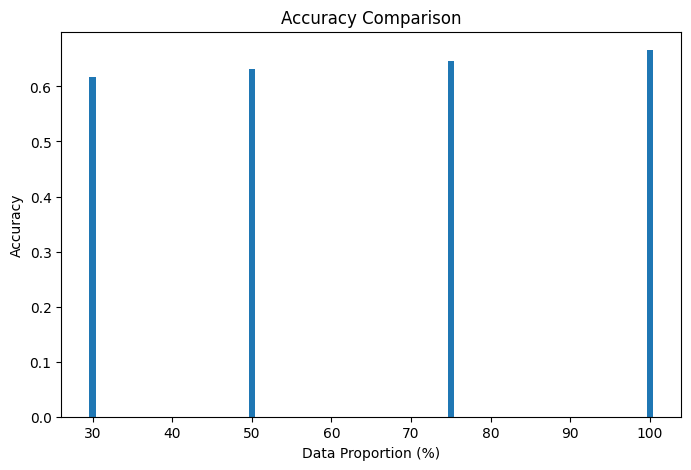

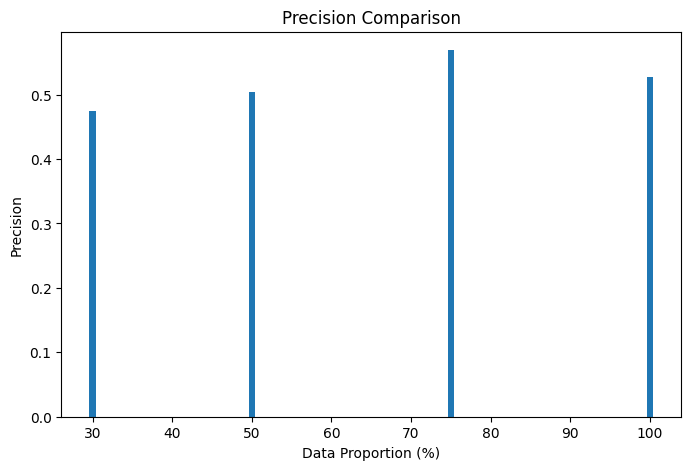

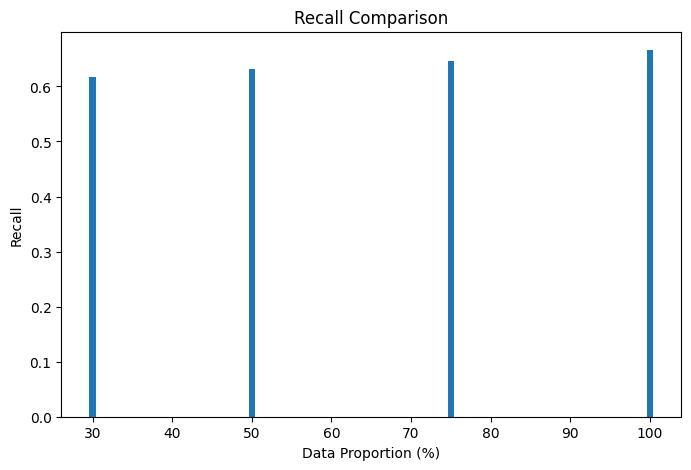

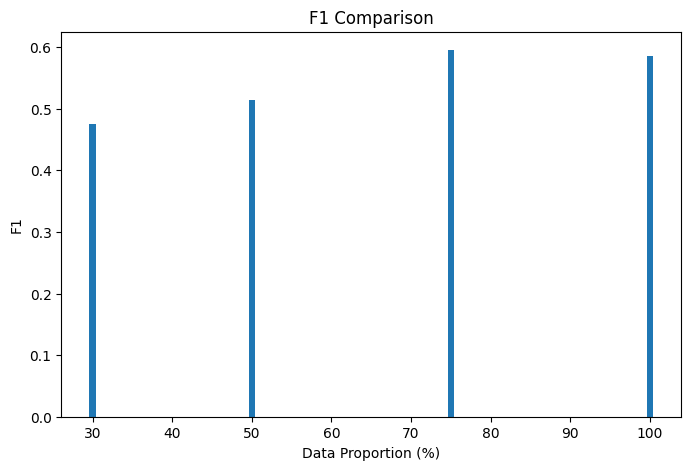

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import matplotlib.pyplot as plt

# Load and Preprocess Data
df_train_orig = pd.read_csv("/content/drive/MyDrive/Disseration UON/Datasets/tamil_train.csv", sep="\t", names=["class", "comments"])
df_test_orig = pd.read_csv("/content/drive/MyDrive/Disseration UON/Datasets/tamil_test.csv", sep="\t", names=["class", "comments"])

# Apply preprocessing
df_train_orig['comments'] = df_train_orig['comments'].apply(preprocessing)
df_test_orig['comments'] = df_test_orig['comments'].apply(preprocessing)

# Encode the labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_train_orig['class'] = label_encoder.fit_transform(df_train_orig['class'])
df_test_orig['class'] = label_encoder.transform(df_test_orig['class'])

# List to store performance metrics
metrics_list = []

# Loop through different data proportions
RED_BOLD = "\033[1;31m"
RESET = "\033[0m"

for proportion in [0.3, 0.5, 0.75, 1.0]:
    print(f"{RED_BOLD}Training with {int(proportion * 100)}% of data...{RESET}")

    # Sample the training data
    df_train = df_train_orig.sample(frac=proportion, random_state=42)

    # Prepare training and testing data
    X_train = df_train['comments'].tolist()
    y_train = df_train['class'].tolist()
    X_test = df_test_orig['comments'].tolist()
    y_test = df_test_orig['class'].tolist()

    # Tokenize the data
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)
    test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128)

    class Dataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    train_dataset = Dataset(train_encodings, y_train)
    test_dataset = Dataset(test_encodings, y_test)

    # Initialize the BERT model
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

    # Function to compute accuracy
    def compute_metrics(p):
        preds = np.argmax(p.predictions, axis=1)
        return {
            'accuracy': accuracy_score(p.label_ids, preds)
        }

    # Training Arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=10,
        per_device_train_batch_size=64,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",  # Evaluate at the end of each epoch
        save_strategy="epoch",        # Save model at the end of each epoch
        load_best_model_at_end=True,  # Load the best model after training
        metric_for_best_model="accuracy",  # Use accuracy to determine best model
        greater_is_better=True,       # Higher accuracy is better
        eval_accumulation_steps=10,   # Accumulate gradients over 10 steps
        save_total_limit=2,           # Keep only the best 2 checkpoints
        report_to="none"              # Disable reporting to external trackers
    )

    # Early stopping callback
    early_stopping = EarlyStoppingCallback(
        early_stopping_patience=5,    # Stop if no improvement after 5 epochs
        early_stopping_threshold=0.01  # Minimum improvement threshold
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping]
    )

    # Train the model
    trainer.train()

    # Get predictions on the test set
    predictions = trainer.predict(test_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    # Compute accuracy, precision, recall, F1 score
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    # Store the metrics
    metrics_list.append({
        'proportion': int(proportion * 100),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })
    # Print Classification Report for each data proportion
    print(f"\nClassification Report for {int(proportion * 100)}% of data:")

    # Check unique classes in the test set and predictions
    unique_labels = np.unique(labels)

    # Print classification report
    print(classification_report(labels, preds, labels=unique_labels, target_names=label_encoder.inverse_transform(unique_labels)))


# Plotting the metrics
metrics_df = pd.DataFrame(metrics_list)

# Plotting function for metrics
def plot_metrics(metric_name):
    plt.figure(figsize=(8, 5))
    plt.bar(metrics_df['proportion'], metrics_df[metric_name])
    plt.xlabel('Data Proportion (%)')
    plt.ylabel(metric_name.capitalize())
    plt.title(f'{metric_name.capitalize()} Comparison')
    plt.show()

# Plot accuracy, precision, recall, and F1 score
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    plot_metrics(metric)


# Data Augmentation for RNN and Bi-LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional, Dense
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

# Function for RNN Model (without embedding layer)
def run_rnn(x_train, y_train, x_test, y_test):
    model = Sequential()
    model.add(SimpleRNN(128, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(9, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

    predicted = model.predict(x_test).argmax(axis=1)
    return model, predicted, y_test

# Function for BiLSTM Model (without embedding layer)
def run_bilstm(x_train, y_train, x_test, y_test):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2]))))
    model.add(Dense(9, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

    predicted = model.predict(x_test).argmax(axis=1)
    return model, predicted, y_test

# Function to show classification report and confusion matrix
def show_results(predicted, y_test):
    print("Classification Report:")
    print(classification_report(y_test, predicted,digits=4))

# Prepare datasets (resize the data for RNN/LSTM models)
X_train_charwb_resize = np.expand_dims(X_train_charwb, axis=1)
X_test_charwb_resize = np.expand_dims(X_test_charwb, axis=1)

# List of proportions to split the training data
proportions = [0.33, 0.5, 0.75]

for proportion in proportions:
    print(f"Training with {int(proportion * 100)}% of the dataset...")

    # Split the training data into the desired proportion
    X_train_sample, _, y_train_sample, _ = train_test_split(X_train_charwb_resize, Y_train, train_size=proportion, random_state=42)

    # Run RNN model
    clf_rnn, pred_rnn, y_test_rnn = run_rnn(X_train_sample, y_train_sample, X_test_charwb_resize, Y_val)
    print(f"Results for RNN model with {int(proportion * 100)}% training data:")
    show_results(pred_rnn, Y_val)

    # Run BiLSTM model
    clf_bilstm, pred_bilstm, y_test_bilstm = run_bilstm(X_train_sample, y_train_sample, X_test_charwb_resize, Y_val)
    print(f"Results for BiLSTM model with {int(proportion * 100)}% training data:")
    show_results(pred_bilstm, Y_val)


Training with 33% of the dataset...
Epoch 1/10
24/24 [==============================] - 2s 17ms/step - loss: 1.7132 - accuracy: 0.5521 - val_loss: 1.3253 - val_accuracy: 0.6250
Epoch 2/10
24/24 [==============================] - 0s 6ms/step - loss: 1.2788 - accuracy: 0.6049 - val_loss: 1.2108 - val_accuracy: 0.6857
Epoch 3/10
24/24 [==============================] - 0s 6ms/step - loss: 1.1407 - accuracy: 0.6671 - val_loss: 1.1241 - val_accuracy: 0.6821
Epoch 4/10
24/24 [==============================] - 0s 6ms/step - loss: 1.0319 - accuracy: 0.6698 - val_loss: 1.0807 - val_accuracy: 0.6911
Epoch 5/10
24/24 [==============================] - 0s 6ms/step - loss: 0.9403 - accuracy: 0.7091 - val_loss: 1.0420 - val_accuracy: 0.6821
Epoch 6/10
24/24 [==============================] - 0s 6ms/step - loss: 0.8559 - accuracy: 0.7050 - val_loss: 1.0228 - val_accuracy: 0.6929
Epoch 7/10
24/24 [==============================] - 0s 6ms/step - loss: 0.7732 - accuracy: 0.7510 - val_loss: 1.0021 - val_

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for RNN model with 33% training data:
Classification Report:
              precision    recall  f1-score   support

           0     0.1818    0.0556    0.0851        36
           1     0.3333    0.2500    0.2857         8
           2     0.2857    0.1818    0.2222        11
           3     0.5593    0.6346    0.5946       104
           4     0.4000    0.0833    0.1379        24
           5     0.7341    0.8699    0.7963       346
           7     0.0000    0.0000    0.0000         2
           8     0.0000    0.0000    0.0000        29

    accuracy                         0.6696       560
   macro avg     0.3118    0.2594    0.2652       560
weighted avg     0.5967    0.6696    0.6223       560

Epoch 1/10
24/24 [==============================] - 3s 25ms/step - loss: 1.9205 - accuracy: 0.5562 - val_loss: 1.5346 - val_accuracy: 0.6179
Epoch 2/10
24/24 [==============================] - 0s 9ms/step - loss: 1.4161 - accuracy: 0.5724 - val_loss: 1.2964 - val_accuracy: 0.6250

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


35/35 [==============================] - 1s 11ms/step - loss: 1.5711 - accuracy: 0.5670 - val_loss: 1.2453 - val_accuracy: 0.6321
Epoch 2/10
35/35 [==============================] - 0s 4ms/step - loss: 1.2017 - accuracy: 0.6375 - val_loss: 1.1228 - val_accuracy: 0.6804
Epoch 3/10
35/35 [==============================] - 0s 4ms/step - loss: 1.0545 - accuracy: 0.6652 - val_loss: 1.0514 - val_accuracy: 0.6839
Epoch 4/10
35/35 [==============================] - 0s 4ms/step - loss: 0.9369 - accuracy: 0.6920 - val_loss: 1.0057 - val_accuracy: 0.6875
Epoch 5/10
35/35 [==============================] - 0s 4ms/step - loss: 0.8360 - accuracy: 0.7152 - val_loss: 0.9777 - val_accuracy: 0.6911
Epoch 6/10
35/35 [==============================] - 0s 4ms/step - loss: 0.7502 - accuracy: 0.7384 - val_loss: 0.9614 - val_accuracy: 0.6750
Epoch 7/10
35/35 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.7714 - val_loss: 0.9477 - val_accuracy: 0.6732
Epoch 8/10
35/35 [============

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for RNN model with 50% training data:
Classification Report:
              precision    recall  f1-score   support

           0     0.4615    0.1667    0.2449        36
           1     0.3333    0.2500    0.2857         8
           2     0.2857    0.1818    0.2222        11
           3     0.5263    0.6731    0.5907       104
           4     0.2000    0.0833    0.1176        24
           5     0.7506    0.8439    0.7946       346
           7     0.0000    0.0000    0.0000         2
           8     0.0000    0.0000    0.0000        29

    accuracy                         0.6679       560
   macro avg     0.3197    0.2749    0.2820       560
weighted avg     0.6102    0.6679    0.6299       560

Epoch 1/10
35/35 [==============================] - 3s 20ms/step - loss: 1.7751 - accuracy: 0.5679 - val_loss: 1.3644 - val_accuracy: 0.6196
Epoch 2/10
35/35 [==============================] - 0s 6ms/step - loss: 1.3250 - accuracy: 0.5884 - val_loss: 1.2188 - val_accuracy: 0.6589

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


53/53 [==============================] - 2s 9ms/step - loss: 1.4951 - accuracy: 0.5792 - val_loss: 1.1813 - val_accuracy: 0.6750
Epoch 2/10
53/53 [==============================] - 0s 4ms/step - loss: 1.1362 - accuracy: 0.6494 - val_loss: 1.0566 - val_accuracy: 0.6839
Epoch 3/10
53/53 [==============================] - 0s 4ms/step - loss: 0.9856 - accuracy: 0.6738 - val_loss: 0.9940 - val_accuracy: 0.6964
Epoch 4/10
53/53 [==============================] - 0s 4ms/step - loss: 0.8736 - accuracy: 0.7065 - val_loss: 0.9565 - val_accuracy: 0.6857
Epoch 5/10
53/53 [==============================] - 0s 4ms/step - loss: 0.7863 - accuracy: 0.7208 - val_loss: 0.9342 - val_accuracy: 0.6875
Epoch 6/10
53/53 [==============================] - 0s 4ms/step - loss: 0.7125 - accuracy: 0.7494 - val_loss: 0.9361 - val_accuracy: 0.6696
Epoch 7/10
53/53 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.7756 - val_loss: 0.9052 - val_accuracy: 0.6768
Epoch 8/10
53/53 [=============

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for RNN model with 75% training data:
Classification Report:
              precision    recall  f1-score   support

           0     0.2500    0.1111    0.1538        36
           1     0.2500    0.1250    0.1667         8
           2     0.1667    0.0909    0.1176        11
           3     0.5888    0.6058    0.5972       104
           4     0.2500    0.1250    0.1667        24
           5     0.7379    0.8786    0.8021       346
           7     0.0000    0.0000    0.0000         2
           8     0.3333    0.0345    0.0625        29

    accuracy                         0.6732       560
   macro avg     0.3221    0.2464    0.2583       560
weighted avg     0.6161    0.6732    0.6315       560

Epoch 1/10
53/53 [==============================] - 3s 14ms/step - loss: 1.6590 - accuracy: 0.5679 - val_loss: 1.2746 - val_accuracy: 0.6286
Epoch 2/10
53/53 [==============================] - 0s 6ms/step - loss: 1.2486 - accuracy: 0.6226 - val_loss: 1.1271 - val_accuracy: 0.6804

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
